##### Common Alpha Factors

In [1]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from pathlib import Path
import numpy as np
import pandas as pd
import gc

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

##### Load Data

In [4]:
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

lock_path = "/tmp/assets_h5_file.lock"  # Choose a path for the lock file

from filelock import FileLock

with FileLock(lock_path):
    with pd.HDFStore(DATA_STORE) as store:
        data = store['data/top500_dataset']

In [5]:
# with pd.HDFStore(DATA_STORE) as store:
#     store.put('factors/common', df_optimized)
data.rename(columns={'market cap': \
    'market_cap'}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1336327 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZTS', Timestamp('2023-08-10 00:00:00'))
Data columns (total 20 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   open            1336327 non-null  float32
 1   high            1336327 non-null  float32
 2   low             1336327 non-null  float32
 3   close           1336327 non-null  float32
 4   volume          1336327 non-null  float64
 5   market_cap      1336327 non-null  float64
 6   sector          1336327 non-null  float32
 7   ret_frac_order  1336327 non-null  float32
 8   ret_01d         1336327 non-null  float32
 9   ret_02d         1336327 non-null  float32
 10  ret_03d         1336327 non-null  float32
 11  ret_04d         1336327 non-null  float32
 12  ret_05d         1336327 non-null  float32
 13  ret_10d         1336327 non-null  float32
 14  ret_21d         1336327 non-null  float32
 15  ret_42d   

##### TA-Lib: Function Groups

List number of available functions by group

In [6]:
function_groups = ['Overlap Studies',
                   'Momentum Indicators',
                   'Volume Indicators',
                   'Volatility Indicators',
                   'Price Transform',
                   'Cycle Indicators',
                   'Pattern Recognition',
                   'Statistic Functions',
                   'Math Transform',
                   'Math Operators']

talib_grps = talib.get_function_groups()

In [7]:
import pandas as pd
import talib.abstract as ta
import logging
import talib
import numpy as np

# The 5 days can be seen as a very short-term trend.
# The 21 days can be used to determine the medium-term trend.
# The 63 days can be viewed as a longer-term trend.

def compute_talib_indicators(df, function_groups, timeperiods=[5, 21, 63]):
    """
    Compute indicators for the specified function groups using TA-Lib's Abstract API.
    
    Parameters:
    - df: DataFrame with columns 'open', 'high', 'low', 'close', and optionally 'volume'.
    - function_groups: List of function groups to compute.
    """
    
    # Organize data in the format needed for TA-Lib Abstract API
    inputs = {
        'open': df['open'].astype(float).values,
        'high': df['high'].astype(float).values,
        'low': df['low'].astype(float).values,
        'close': df['close'].astype(float).values,
        'volume': df['volume'].astype(float).values if 'volume' in df.columns else np.random.random(len(df))
    }

    talib_functions = {k: v for k, v in talib.get_function_groups().items() if k in function_groups}

    success_count = 0
    failure_count = 0
    
    for group, indicators in talib_functions.items():
        for indicator_name in indicators:
            for timeperiod in timeperiods:
                try:
                    indicator_func = ta.Function(indicator_name)

                    parameters = {}
                    if 'timeperiod' in indicator_func.parameters:
                        parameters['timeperiod'] = timeperiod

                    if indicator_name == 'MAVP':
                        inputs['periods'] = np.full(len(df), timeperiod, dtype=np.float64)

                    outputs = indicator_func(inputs, **parameters)

                    # For multi-output functions, like 'BBANDS'
                    if isinstance(outputs, (list, tuple)):
                        for i, out_name in enumerate(indicator_func.output_names):
                            col_name = f"{out_name}_{timeperiod}".upper()
                            df[col_name] = outputs[i]
                    else:
                        col_name = f"{indicator_name}_{timeperiod}".upper()
                        df[col_name] = outputs

                    success_count += 1
                except Exception as e:
                    logging.warning(f"{indicator_name}_{timeperiod} failed due to: {str(e)}")
                    failure_count += 1

    print(f"{success_count} indicators added successfully.")
    print(f"{failure_count} indicators failed.")

    return df

function_groups = [
    'Overlap Studies',
    'Momentum Indicators',
    'Volume Indicators',
    'Volatility Indicators',
    'Price Transform',
    'Cycle Indicators',
    'Pattern Recognition',
    'Statistic Functions',
    'Math Transform',
    'Math Operators'
]

# Assuming you've read your dataframe into a variable named 'data'
data_ta = compute_talib_indicators(data.copy(), function_groups)

474 indicators added successfully.
0 indicators failed.


In [8]:
data_ta.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1336327 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZTS', Timestamp('2023-08-10 00:00:00'))
Columns: 515 entries, open to OBV_63
dtypes: float32(18), float64(299), int32(198)
memory usage: 4.1+ GB


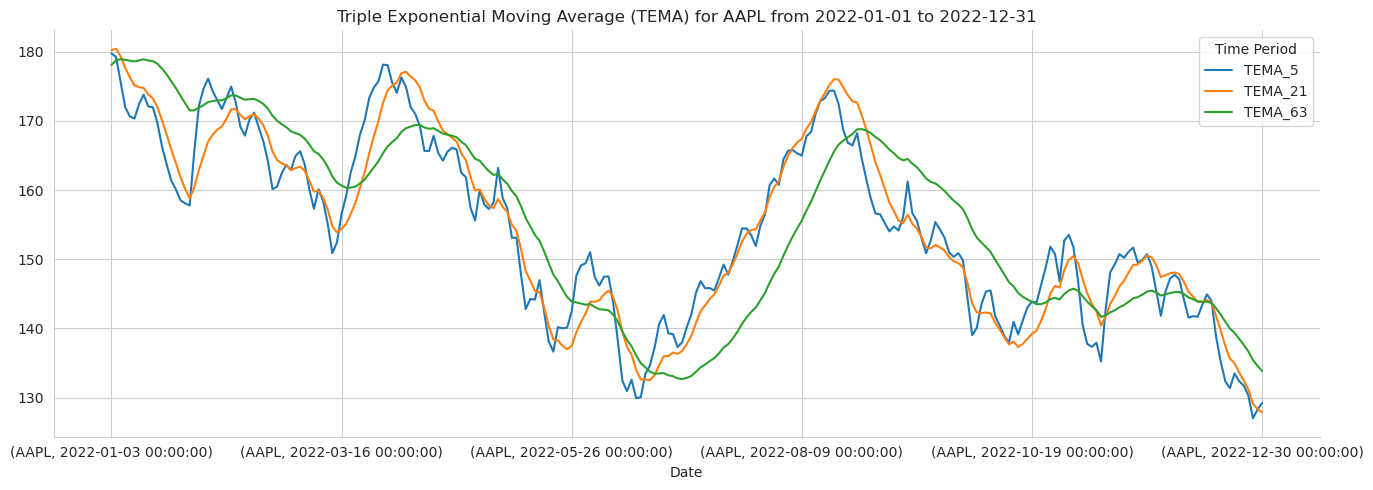

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_tema_for_ticker(data, ticker, start_date, end_date, time_periods=[5, 21, 63]):
    """
    Plot the Triple Exponential Moving Average (TEMA) for a given ticker over a specified time range.
    
    Parameters:
        data (pd.DataFrame): The dataset with multi-index ['ticker', 'date'] and TEMA columns.
        ticker (str): The ticker to plot.
        start_date (str): The start date of the range.
        end_date (str): The end date of the range.
        time_periods (list): List of time periods for which TEMA has been computed. Default is [5, 21, 63].
    """
    
    # Ensure the data's MultiIndex is sorted
    data_sorted = data.sort_index()
    
    # Filter the data for the desired ticker and date range
    filtered_data = data_sorted.loc[(ticker, slice(start_date, end_date)), :]
    
    # Get the relevant TEMA columns
    tema_columns = [f'TEMA_{t}' for t in time_periods]
    df_tema = filtered_data[tema_columns]
    
    # Plot the data
    ax = df_tema.plot(figsize=(14, 5), rot=0, title=f"Triple Exponential Moving Average (TEMA) for {ticker} from {start_date} to {end_date}")
    sns.despine()
    ax.set_xlabel('Date')
    ax.legend(title="Time Period")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_tema_for_ticker(data_ta, 'AAPL', '2022-01-01', '2022-12-31')


In [10]:
from utils import optimize_dataframe
data_ta = optimize_dataframe(data_ta.copy())
data_ta.to_hdf(DATA_STORE, 'data/top500_dataset_with_TA', format='table', mode='a')

Data memory before optimization: 4154.74 MB
Data memory after optimization: 2788.56 MB
Reduced by: 32.88%


In [11]:
del data_ta

##### Rolling Factor Betas

In [12]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=2005)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']

In [13]:
factors = factor_data.columns[:-1]
factors

Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

In [14]:
t = 1
ret = f'ret_{t:02}d'

windows = [21, 63, 252]
for window in windows:
    print(window)
    betas = []
    for ticker, df in data.groupby('ticker', group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret], 
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True).swaplevel()
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}')
    data = data.join(betas)

21
63
252


##### Size proxy

In [15]:
by_ticker = data.groupby('ticker', group_keys=False)
data['size_factor'] = by_ticker.close.apply(lambda x: x.fillna(method='bfill').div(x.iloc[0]))
data['size_proxy'] = data['market_cap'].mul(data.size_factor).div(1e6)

In [16]:
from utils import optimize_dataframe
data = optimize_dataframe(data.copy())
data.to_hdf(DATA_STORE, 'data/top500_dataset_with_rolling_beta_size_proxy', format='table', mode='a')

Data memory before optimization: 1248.15 MB
Data memory after optimization: 885.82 MB
Reduced by: 29.03%


In [17]:
del data

##### Joining the dataframe

In [18]:
import pandas as pd
from pathlib import Path

# Define the path to your data store
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')
CHUNK_SIZE = 10 ** 5  # Define the chunk size based on available memory

# Load the secondary dataset just once for efficiency
beta_size_data = pd.read_hdf(DATA_STORE, 'data/top500_dataset_with_rolling_beta_size_proxy')

# Read the primary dataset in chunks
ta_data_chunks = pd.read_hdf(DATA_STORE, 'data/top500_dataset_with_TA', chunksize=CHUNK_SIZE)

# Prepare an empty list to collect processed chunks
processed_data_list = []

# # Display the initial sizes of datasets
# print(f"Initial shape of beta_size_data: {beta_size_data.shape}")
# print(f"Initial shape of each ta_data_chunks: {CHUNK_SIZE} rows")

for chunk in ta_data_chunks:
    
    # Calculate common columns count for this chunk
    common_columns_count = len(set(beta_size_data.columns).intersection(set(chunk.columns)))
    
    # Indicate progress
    start_val = (chunk.index.get_level_values('ticker')[0], chunk.index.get_level_values('date')[0])
    end_val = (chunk.index.get_level_values('ticker')[-1], chunk.index.get_level_values('date')[-1])
    print(f"Processing rows from {start_val} to {end_val}...")
    
    # Extract unique tickers and dates from the current chunk
    tickers_in_chunk = chunk.index.get_level_values('ticker').unique()
    dates_in_chunk = chunk.index.get_level_values('date').unique()
    
    # Filter beta_size_data based on tickers and dates in the current chunk
    filtered_beta_size_data = beta_size_data[
        beta_size_data.index.get_level_values('ticker').isin(tickers_in_chunk) &
        beta_size_data.index.get_level_values('date').isin(dates_in_chunk)
    ]
    
    # Merge chunk with filtered data
    merged_chunk = chunk.merge(
        filtered_beta_size_data, left_index=True, right_index=True, how='inner', suffixes=('', '_y')
    )
    
    # Drop "_y" suffixed columns (as they come from the secondary dataset)
    merged_chunk = merged_chunk.drop(columns=[col for col in merged_chunk if col.endswith('_y')])

    processed_data_list.append(merged_chunk)

# Concatenate all processed chunks
final_data = pd.concat(processed_data_list)

print(f"Shape of the final combined data: {final_data.shape}")
print("Processing completed.")

Processing rows from ('AA', Timestamp('2013-01-03 00:00:00')) to ('AON', Timestamp('2021-08-09 00:00:00'))...
Processing rows from ('AON', Timestamp('2021-08-10 00:00:00')) to ('BURL', Timestamp('2018-06-08 00:00:00'))...
Processing rows from ('BURL', Timestamp('2018-06-11 00:00:00')) to ('COO', Timestamp('2014-01-27 00:00:00'))...
Processing rows from ('COO', Timestamp('2014-01-28 00:00:00')) to ('DXCM', Timestamp('2019-01-10 00:00:00'))...
Processing rows from ('DXCM', Timestamp('2019-01-11 00:00:00')) to ('FIS', Timestamp('2015-01-16 00:00:00'))...
Processing rows from ('FIS', Timestamp('2015-01-20 00:00:00')) to ('HPQ', Timestamp('2022-03-14 00:00:00'))...
Processing rows from ('HPQ', Timestamp('2022-03-15 00:00:00')) to ('KKR', Timestamp('2013-12-18 00:00:00'))...
Processing rows from ('KKR', Timestamp('2013-12-19 00:00:00')) to ('META', Timestamp('2022-04-29 00:00:00'))...
Processing rows from ('META', Timestamp('2022-05-02 00:00:00')) to ('NTRS', Timestamp('2016-09-23 00:00:00')

In [19]:
final_data.info()

final_data.to_hdf(DATA_STORE, 'factors/common', format='table', mode='a')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10915551 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZTS', Timestamp('2023-08-10 00:00:00'))
Columns: 535 entries, open to size_proxy
dtypes: float32(305), float64(32), int32(198)
memory usage: 23.1+ GB


In [ ]:
# del df_optimized
del final_data